In [1]:
import os
import csv
import math
import re

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

In [2]:
fontsize=14
outfolder="plots"

datasets = [
    "osm_cellids_200M_uint64",
    "wiki_ts_200M_uint64",
    "books_200M_uint64",
    "fb_200M_uint64",
    "osm_cellids_400M_uint64",
    "osm_cellids_600M_uint64",
    "osm_cellids_800M_uint64",
    "books_400M_uint64",
    "books_600M_uint64",
    "books_800M_uint64",
    "books_200M_uint32",
    "normal_200M_uint32",
    "normal_200M_uint64",
    "lognormal_200M_uint32",
    "lognormal_200M_uint64",
    "uniform_dense_200M_uint32",
    "uniform_dense_200M_uint64",
    "uniform_sparse_200M_uint32",
    "uniform_sparse_200M_uint64"
]

def get_ds_name(ds):
    short_name = ds[:ds.find("_", 0, -1)]
    if short_name == "fb":
        return "face"
    elif short_name == "books":
        return "amzn"
    return short_name

def get_ds_size(ds):
    return re.search(r'_([0-9]+M)_', ds, re.IGNORECASE).group(1)

def aggregate(data, num_bins=120):
    data = np.pad(data, (0, max(0, num_bins - len(data))), 'constant')
    bin_width = int(len(data) / num_bins)
    
    res = []
    for b in range(num_bins):
        bin_cnt = 0
        for i in range(b * bin_width, (b+1) * bin_width):
            bin_cnt += data[i]
        res.append(bin_cnt)
        
    return res

(2, 2)


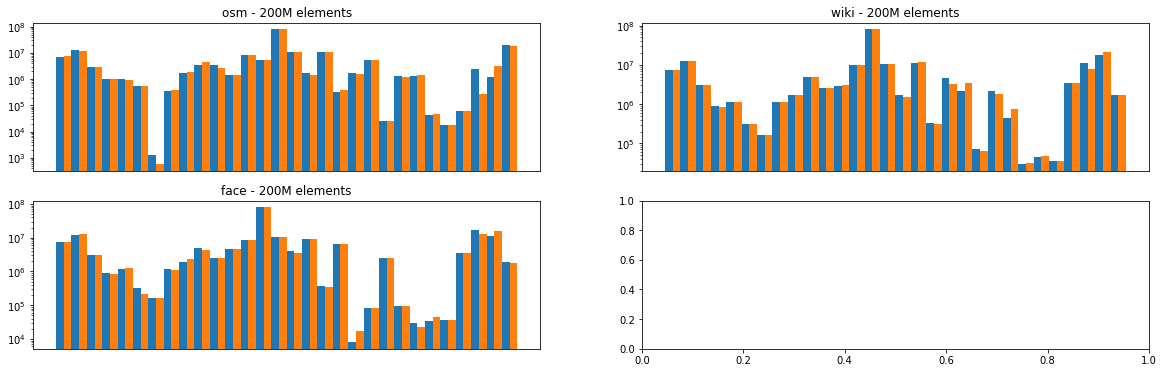

In [19]:
with open("./results/rmi_segments.csv", newline="") as rmi_segs, open("./results/rmi_robust_segments.csv", newline="") as rmi_robust_segs:
    filtered_ds = {"fb_200M_uint64", "osm_cellids_200M_uint64", "wiki_ts_200M_uint64"}#{ds for ds in datasets if "200M" in ds}

    fig_height = 2
    fig_width = int(math.ceil(len(filtered_ds) / fig_height))
    fig, axs = plt.subplots(fig_height, fig_width, figsize=(10 * fig_width, 3 * fig_height))#, sharex=True, sharey=True)
    
    skipped = 0
    for i, dataset in enumerate(datasets):
        rmi = [int(num) for num in rmi_segs.readline().split(",")[1:-1]]
        rmi_rob_1permyriad = [int(num) for num in rmi_robust_segs.readline().split(",")[1:-1]]
        rmi_rob_5permyriad = [int(num) for num in rmi_robust_segs.readline().split(",")[1:-1]]
        rmi_rob_1permille = [int(num) for num in rmi_robust_segs.readline().split(",")[1:-1]]
        rmi_rob_5permille = [int(num) for num in rmi_robust_segs.readline().split(",")[1:-1]]
        rmi_rob_0 = [int(num) for num in rmi_robust_segs.readline().split(",")[1:-1]]
        
        if dataset not in filtered_ds:
            skipped += 1
            continue
            
        x = (i - skipped) % fig_width
        y = int((i - skipped) / fig_width)
        ax = axs[y][x]
        ax.set_yscale("log")
        ax.set_title(f"{get_ds_name(dataset)} - {get_ds_size(dataset)} elements")
        ax.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False
        )
        
        # build histogram with fixed bin size
        rmi = aggregate(rmi)
        rmi_rob_1permille = aggregate(rmi_rob_1permille)
        
        label_pos = np.arange(len(rmi)) 
        bar_width = 1.0 / 2
        ax.bar(label_pos - 0.5 * bar_width, rmi, bar_width, label="rmi")
        ax.bar(label_pos + 0.5 * bar_width, rmi_rob_1permille, bar_width, label="rmi robust 0.1%")
        
        # bar_width = 1.0 / 7.0
        # ax.bar(label_pos - 2.5 * bar_width, rmi, bar_width, label="rmi")
        # ax.bar(label_pos - 1.5 * bar_width, rmi_rob_1permyriad, bar_width, label="rmi robust 0.01%")
        # ax.bar(label_pos - 0.5 * bar_width, rmi_rob_5permyriad, bar_width, label="rmi robust 0.05%")
        # ax.bar(label_pos + 0.5 * bar_width, rmi_rob_1permille, bar_width, label="rmi robust 0.1%")
        # ax.bar(label_pos + 1.5 * bar_width, rmi_rob_5permille, bar_width, label="rmi robust 0.5%")
        # ax.bar(label_pos + 2.5 * bar_width, rmi_rob_0, bar_width, label="rmi robust 0%")

    fig.savefig(f"./plots/rmi_segments.pdf")